# C964 CS Capstone: 

**Predicting if a body of water is potable or not potable**

The purpose of this application is to implement a machine learning model that can be used to predict the potability of a body of water in relation to the following water quality metrics:  

---

1. pH value - Measure of how acidic or basic the water is on a scale of 0 (acidic) to 14 (basic).

2. Hardness - Concentration of dissolved calcium carbonate in miligrams per liter (mg/L).  

3. Solids - Concentration of total dissolved solids in parts per million (ppm). 

4. Chloramines - Concentration of chloramines in parts per million (ppm). 

5. Sulfate - Concentration of sulfate in miligrams per liter (mg/L). 

6. Conductivity - Measure of conductivity is in microsiemens per centimeter (μS/cm)

7. Organic Carbon - Concentration of organic carbon in parts per million (ppm). 

8. Trihalomethanes - Concentration of trihalomethanes in micrograms per liter (µg/l). 

9. Turbidity - Measure of clearness/transparency in nephelometric turbidity units (NTU). 

---

These metrics will determine whether a body of water is potable (1) or not potable (0). Potability refers to whether the water is suitable for consumption, whether its for drinking, cooking, cleaning, or other household purposes. 

In [107]:

import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
import ipywidgets as widgets

# parsing the csv into a dataframe 
df = pd.read_csv('water_potability.csv')

# drop rows containing missing values
df_cleaned = df.dropna()

# remove outliers with a z-score over 2.5 
def remove_outliers(df_cleaned, column):
    z_scores = zscore(df_cleaned[column])
    return df_cleaned[np.abs(z_scores) < 2.5 ]

# Loop over each column in the dataset to remove outliers
for column in df_cleaned.columns:
    df_cleaned = remove_outliers(df_cleaned, column)

df_cleaned

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0
...,...,...,...,...,...,...,...,...,...,...
3264,5.893103,239.269481,20526.666156,6.349561,341.256362,403.617560,18.963707,63.846319,4.390702,1
3265,8.197353,203.105091,27701.794055,6.472914,328.886838,444.612724,14.250875,62.906205,3.361833,1
3267,8.989900,215.047358,15921.412018,6.297312,312.931022,390.410231,9.899115,55.069304,4.613843,1
3268,6.702547,207.321086,17246.920347,7.708117,304.510230,329.266002,16.217303,28.878601,3.442983,1


1544 records were removed after cleaning the dataset, leaving behind 1732 records representing 1732 bodies of water. 

The dataset has 10 columns. Some columns such as 'pH' and 'Solids' use wildly different ranges; pH values range from 0-14 while Solids values are in the tens of thousands. The data will need to be scaled later to fit our logistic regression model. 

In [108]:
# 0 = not potable | 1 = potable
df_cleaned['Potability'].value_counts()

Potability
0    1057
1     675
Name: count, dtype: int64

In [109]:
logistic_model = LogisticRegression(max_iter=3000)

# dependent variable y = potability 
y = df_cleaned.iloc[:,9]

# independent variables x = all other metrics except for potability
x = df_cleaned.iloc[:,:-1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

# scaling the data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

logistic_model.fit(x_train_scaled, y_train)

y_prediction = logistic_model.predict(x_test_scaled)

accuracy = accuracy_score(y_test, y_prediction)
print(f"Accuracy score: {accuracy}")

Accuracy score: 0.6038461538461538


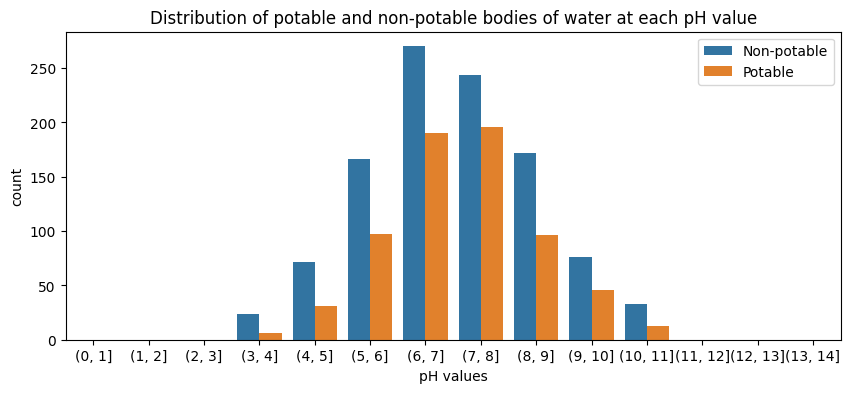

In [110]:
# create a bar chart to plot potability against pH values 

df_bar = df_cleaned.copy()

df_bar['pH_bin'] = pd.cut(df_bar['ph'], bins=range(0,15,1))

plt.figure(figsize=(10,4))
sns.countplot(x='pH_bin', hue='Potability', data=df_bar)

plt.title('Distribution of potable and non-potable bodies of water at each pH value')
plt.xlabel('pH values')
plt.legend(labels=['Non-potable', 'Potable'])


This bar chart shows the distribtion of potable and non-potable bodies of water in the cleaned dataset across different pH levels. 

Overall, the ratio of potable vs non-potable bodies of water appears to be close to even near the middle of the graph (pH 6-7, 7-8, 7-9) and becomes more skewed towards non-potable when approaching either end (ph 3-4, 10-11). 

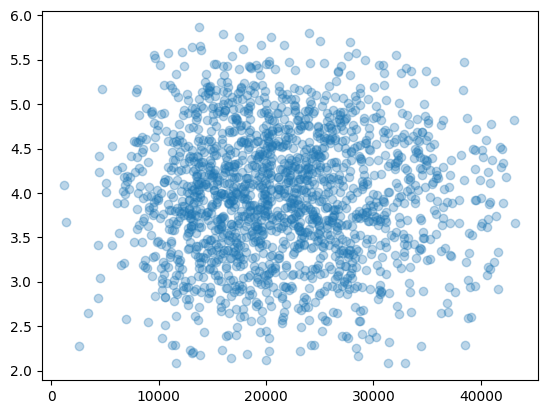

In [111]:
# create scatter plot to visualize correlation between 2 variables: sulfate and turbidity. 

plt.scatter(df_cleaned['Solids'], df_cleaned['Turbidity'], alpha=0.3)

plt.show()

This scatterplot visualizes the relationship between solids concentration and turbidity. 

Initially, it was assumed that a high solids concentration would result in high turbidity, but this graph shows a fairly random spread with no significant relationship between the two variables.

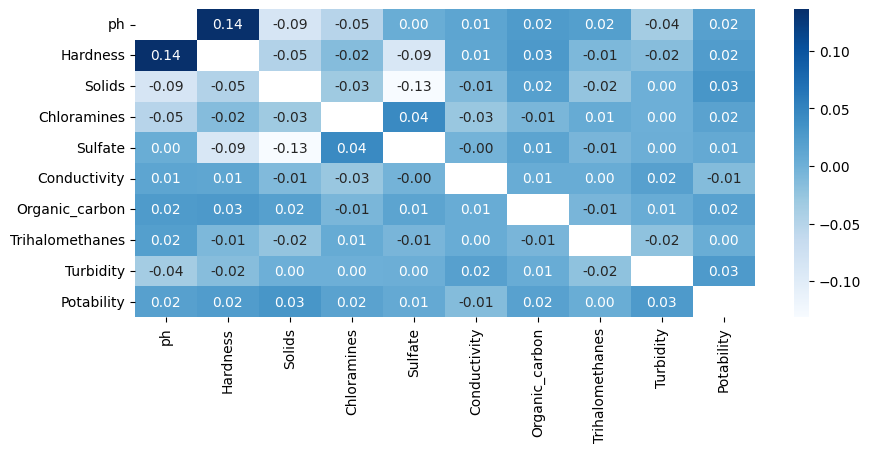

In [112]:
# create heatmap to visualize correlation strength between the variables

matrix = df_cleaned.corr()

plt.figure(figsize=(10,4))

np.fill_diagonal(matrix.values, np.nan)

sns.heatmap(matrix, annot=True, cmap='Blues', fmt='.2f', mask=np.isnan(matrix))

plt.show()


This heatmap shows the correlation strength between the variables. 

Some notables: pH and hardness have a high positive correlation with each other. Sulfate concentration and solids concentration have a high negative correlation with each other. 